In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
import pickle
import plotly.express as px

from sklearn.model_selection import train_test_split

Loading data from .csv

In [2]:
#Plants data loading and creation of a list with DataFrames

directory_path = "dataset/"

files_names = [file for file in os.listdir(directory_path)]

#remove the extension from the file names
names = []
for i in files_names:
    names.append(i[:-4])

#load the data into a list of DataFrames with number of the plant, generation, poa and clipping
df_list = []

for name, j in zip(files_names, names):
    df_list.append(pd.read_csv(directory_path + name, encoding = 'latin1'))

In [4]:
df_list[2].head(48)

,muestra,generacion,poa,clipping
0,0,0.000000,0.000000,0
1,0,0.000000,0.000000,0
2,0,0.000000,0.000000,0
3,0,0.000000,0.000000,0
4,0,0.000000,0.000000,0
5,0,0.000000,0.000000,0
6,0,0.000000,0.000000,0
7,0,0.000000,0.000000,0
8,0,0.000000,0.000000,0
9,0,0.000000,0.000000,0


In the "clipping" column, a 1 indicates that there is clipping at that moment, and a 0 indicates that there is none.

Clipping Distribution

In [5]:
clipping_distribution = 0
for df in df_list:
    samples = df['muestra'].unique() 
    for vector in samples:
        l_df = np.array(df[df["muestra"] == vector]['clipping'].values)
        clipping_distribution += l_df

In [22]:
df = pd.DataFrame({'time': range(48), 'Count': clipping_distribution})

fig = px.bar(df, x='time', y='Count')

fig.update_layout(
    title='Clipping Distribution',
    xaxis_title='Time (every 30 min)',
    yaxis_title='Count',
    showlegend=False,
    width=800,
    height=600
)

fig.show()

To determine if it's possible to reduce the vector's dimensionality, I calculate the distribution of clipping across the samples. As we can see, it's possible to remove certain values at the ends. There are other techniques, such as dimensionality reduction, to determine which values can be dropped. However, in this case, it's possible to easily identify those values and avoid using too much computing time.

Useful functions

In [6]:
def extract_samples(dataframe, cutting = 1):
    '''function to extract the generation vectors for each dataframe
    
    Args:
    dataframe: pandas DataFrame
    cutting: int, optional, default 1. Number of times to cut the vector

    Returns:
    samples: list, normalized vectors
    labels: list, clipping labels
    vectors: list, not normalized vectors
    '''

    values = dataframe["muestra"].unique()
    samples, labels, vectors = [], [], []

    for i in values:
        l_df = dataframe[dataframe["muestra"] == i]
        if np.isnan(l_df["generacion"].values).any() == True:
            continue

        v_gen = l_df["generacion"].values
        v_clip = l_df["clipping"].values
        v_poa = l_df["poa"].values

        #Remove negative values
        v_gen = [0 if x < 0 else x for x in v_gen]
        v_poa = [0 if x < 0 else x for x in v_poa]

        maximo = max( max(v_gen), max(v_poa))

        #Take out the first and last 4 values (it corresponde to the first 6 hrs and the last 2 hrs of the day)
        for i in range(cutting):
            v_gen = v_gen[12:-4]
            v_clip = v_clip[12:-4]
            v_poa = v_poa[12:-4]

        #TO DO: make shure that this part of the code it's necessary
        if np.isnan(v_gen).any() == True:
            continue
        if np.isnan(v_poa).any() == True:
            continue

        # Vectors not normalized
        vectors.append([v_poa, v_gen])   

        # Vectors normalized
        v_gen = v_gen/maximo
        v_poa = v_poa/maximo
        samples.append([v_poa, v_gen])

        labels.append(v_clip)

    return samples, labels, vectors


def example_plot(curves, n):
    '''Function to plot the generation and poa curves
    
    Args:
    curves: list, list of curves
    n: int, number of the curve to plot
    '''
    plt.title("Generated and teorical vectors example")
    plt.plot(curves[n][0])
    plt.plot(curves[n][1])
    plt.legend(["Teorical", "Generation"])
    plt.xlabel("Time")
    plt.ylabel("Normalized generation")

Creating dataset and train/test vectors

In [7]:
n_vectores = []
label = []
vectores = []

for d_frame in df_list:
    result = extract_samples(d_frame, cutting = 1)
    for i, j,k in zip(result[0], result[1], result[2]):
        n_vectores.append(i)
        label.append(j)
        vectores.append(k)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(n_vectores, label, test_size=0.3, random_state=0)
x_train_flat = np.array([np.concatenate(x) for x in x_train])
x_test_flat = np.array([np.concatenate(x) for x in x_test])

How it looks a vector

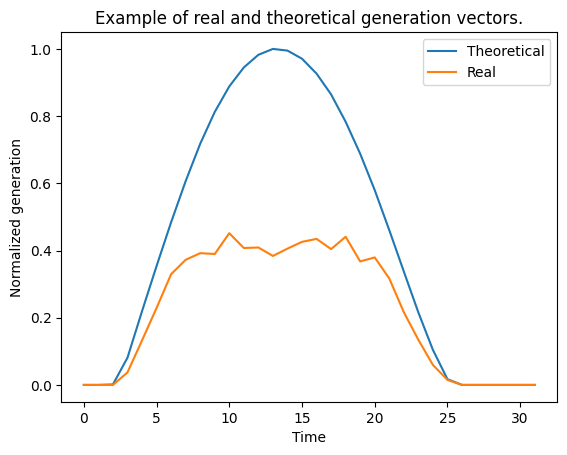

In [11]:
example_plot(n_vectores, 300)
plt.title("Example of real and theoretical generation vectors.")
plt.xlabel("Time")
plt.ylabel("Normalized generation")
plt.legend(["Theoretical", "Real"])

In [47]:
# Save the variables in a pkl file

with open("data/variables.pkl", "wb") as archivo:
    pickle.dump((n_vectores, label, vectores), archivo)